In [40]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample0815.csv')

In [3]:
d_ms.head()

,Average Rt(min),Average Mz,S/N average,20180815_CEC_CAL-8-no4_MSpos_1,20180815_CEC_CAL-8-no4_MSpos_2,20180815_CEC_CAL-8-no4_MSpos_3,20180815_CEC_CAL-8-no4_MSpos_4,20180815_CEC_CAL-8-no4_MSpos_5,20180815_CEC_CAL-8-no4_MSpos_6,20180815_CEC_CAL-8-no4_MSpos_7,...,20180815_SR520-Creek_Mix6A_3,20180815_SR520-Creek_Mix6B_1,20180815_SR520-Creek_Mix6B_2,20180815_SR520-Creek_Mix6B_3,20180815_Swan-Creek-Dec_1,20180815_Swan-Creek-Dec_2,20180815_Swan-Creek-Dec_3,20180815_Swan-Creek-May_1,20180815_Swan-Creek-May_2,20180815_Swan-Creek-May_3
0,8.273,100.03867,40.44,0,0,88,0,0,89,0,...,238,113,184,202,0,0,0,0,76,0
1,8.304,100.03956,77.03,0,0,88,0,0,88,0,...,238,217,184,202,0,0,0,0,73,0
2,7.097,100.07603,52.53,64,231,104,247,259,145,294,...,1375,1139,511,1159,1201,1337,1723,573,2585,1585
3,5.226,100.11173,31.39,1629,882,1850,2217,1254,946,1095,...,18206,20583,20713,19942,21409,21764,23078,18056,18226,17470
4,4.944,100.11175,14.70,759,934,396,1676,583,639,336,...,10508,8889,14385,6274,12796,14584,13262,7576,12092,11060


In [4]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [5]:
def d_clean(dataframe, rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000): #Update with *args or **args in future updates
    #Area thres update
    drop_index = np.argwhere(np.asarray(dataframe[dataframe.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1)
    df_c = dataframe.drop(drop_index[0])
    
    df_c = df_c[(df_c['Average RT (min)'] > rt_range[0]) & (df_c['Average RT (min)'] < rt_range[1])]
    df_c = df_c[(df_c['Average m/z'] > mz_range[0]) & (df_c['Average m/z'] < mz_range[1])]
    df_c = df_c[df_c['Average sn'] >= sn_thres]
    df_c = df_c[df_c['Average score'] >= score_thres]
    df_c.reset_index(inplace=True)
    df_c.drop(columns=['index'],inplace=True)
    
    return df_c

In [6]:
df_c = d_clean(d_ms,rt_range = [1,30], mz_range = [200,800], area_thres=500)

In [7]:
#Distinguish between sample and blank
col_blank = [col for col in df_c.columns if 'CEC' in col or 'Blank' in col or 'ISTD' in col or 'Wash' in col or 'Shutdown' in col]
col_sample = [col for col in df_c.columns if col not in col_blank]

In [9]:
#sample vs blank threshold
samplevsblank_thres = 10
d_sample = df_c[df_c[col_sample[4:]].max(axis=1) / df_c[col_blank].mean(axis=1) > samplevsblank_thres][col_sample]
d_sample.reset_index(inplace=True)
d_sample.drop(columns=['index'],inplace=True)

In [10]:
#Noise removal from triplicates
trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])] #Needs to define 1. parser 2. position of parsing

In [11]:
empty_tol = 0
mvm_tol = 10

for triplicate in tqdm(trip_list):
    for index, row in d_sample[triplicate].iterrows():
        if (row == 0).sum() > empty_tol:
            d_sample.loc[index, triplicate] = 0
            #Filling the gaps and check variance? --- CV filter
#         elif row.max() / row.mean() > mvm_tol:
#             d_sample.loc[index, triplicate] = 0

100%|██████████| 9/9 [02:26<00:00, 16.30s/it]


In [12]:
#Double check if any empty columns and clean up
d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]

In [78]:
#visualization
#Normalization to 0 1 scale
c_data=d_sample[4:].values #returns a numpy array
#Normalized to absolute values
for row in c_data:
    row = row/max(row)
#Normalized to relative values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(c_data.T)
df = pd.DataFrame(x_scaled).T

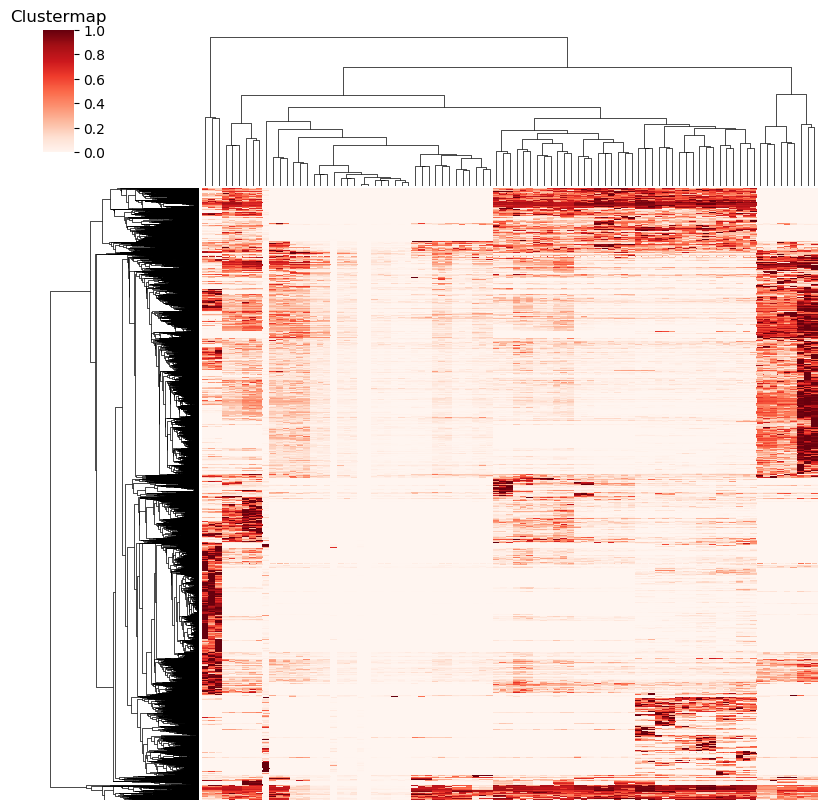

In [79]:
#no 0 is acceptable in the clustermap
sns.clustermap(df.values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False)
plt.title('Clustermap')
plt.show()

# whole batch or only dilution series
whole batch to start with the testing, then apply extra filter to filter out cases, one exist both in source and non-source sample and etc.

In [13]:
#normalization of the dataset for statistical analysis -- unsupervised machine learning
#Q: is the normalization needed to terminate the effect of peak area variation?
#option: random forest, som, pca+k-means
#option2: non-parametric test
d_sample.head()

,Average RT (min),Average m/z,Average sn,Average score,20180815_Coulter-Creek-May_1,20180815_Coulter-Creek-May_2,20180815_Coulter-Creek-May_3,20180815_Crescent-Creek-Jan_1,20180815_Crescent-Creek-Jan_2,20180815_Crescent-Creek-Jan_3,...,20180815_SR520-Creek_Mix6A_3,20180815_SR520-Creek_Mix6B_1,20180815_SR520-Creek_Mix6B_2,20180815_SR520-Creek_Mix6B_3,20180815_Swan-Creek-Dec_1,20180815_Swan-Creek-Dec_2,20180815_Swan-Creek-Dec_3,20180815_Swan-Creek-May_1,20180815_Swan-Creek-May_2,20180815_Swan-Creek-May_3
0,8.381,200.04636,9.85,1,5520,11208,5499,30277,6087,12761,...,11867,16143,9538,7513,12569,13390,16329,3868,7647,3711
1,8.326,200.04755,17.23,1,31435,10739,43573,27776,10074,22430,...,13405,16143,15061,16500,9351,9545,18518,6118,10946,5523
2,5.630,200.07532,32.75,1,1772,1193,1470,1635,1258,3545,...,2272,1755,1478,2092,2444,1473,472,710,979,581
3,5.718,200.12758,45.73,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.170,200.12761,18.43,1,3256,3790,948,2253,1292,949,...,962,3579,3137,1880,1281,2800,2111,1005,1172,1114


In [14]:
#PCA -- other transformation is needed
from sklearn.preprocessing import StandardScaler
df_pca=d_sample.iloc[:,4:]
x = df_pca.values
# Standardizing the features
x = StandardScaler().fit_transform(x)

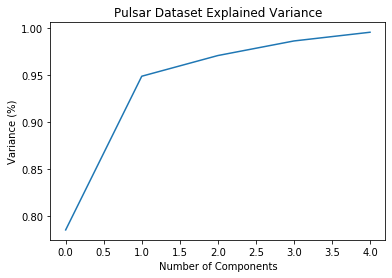

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x) #X : array-like, shape (n_samples, n_features)

# Plotting the Cumulative Sum of the Explained Variance, use explained variance to choose number of principle componenets
# you may choose number of componenets that explained > 99% variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [20]:
(pca.explained_variance_ratio_).cumsum()

array([0.78495832, 0.94903259, 0.97110997, 0.9866875 , 0.99598908])

In [21]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-0.373304,0.052295
1,-0.360529,0.059731
2,-0.357528,0.025405
3,-0.360193,0.023667
4,-0.343193,0.014078


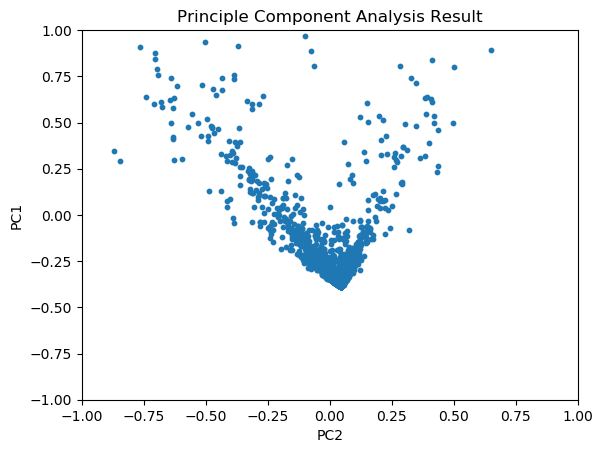

In [34]:
plt.style.use('default')
finalDf = principalDf
principle_1 = finalDf.loc[:,'principal component 1']
principle_2 = finalDf.loc[:,'principal component 2']
n = list(df_pca.columns)

fig, ax = plt.subplots()
ax.scatter(principle_2, principle_1, s=10)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Principle Component Analysis Result')
plt.xlim(-1,1)
plt.ylim(-1,1)


    
plt.show()